In [43]:
import eons
import neuro
import risp
import speech2spikes
import os
import torchaudio
import torch
import random
import matplotlib.pyplot as plt
import numpy as np

PATH_GUNSHOT_SOUNDS = '/home/joao/dev/MLAudio/shotspotter/data/gunshots'
PATH_NOGUNSHOT_SOUNDS = '/home/joao/dev/MLAudio/shotspotter/data/genBackgrounds'

# Look into possible enabling cumsum (see github)
s2s = speech2spikes.S2S()

# workaround to configure to 12khz sample rate (s2s.configure() didnt work)
s2s._default_spec_kwargs = {
    "sample_rate": 12000,
    "n_mels": 20,
    "n_fft": 512,
    "f_min": 20,
    "f_max": 4000,
    "hop_length": 80,
}
s2s.transform = torchaudio.transforms.MelSpectrogram(**s2s._default_spec_kwargs)

# Some constants
NUM_INPUT_NEURONS = 80 # see paper
NUM_OUTPUT_NEURONS = 2
NUM_SYNAPSES = 1000
NUM_HIDDEN_NEURONS = 250
POP_SIZE = 70

MOA = neuro.MOA()
MOA.seed(23456789, '')

DATASET_CAP = 500

In [5]:
gunshot_file_paths = [PATH_GUNSHOT_SOUNDS+'/'+fn for fn in os.listdir(PATH_GUNSHOT_SOUNDS)][:DATASET_CAP//2]
print(f'We have {len(gunshot_file_paths)} gunshot audio files')
nogunshot_file_paths = [PATH_NOGUNSHOT_SOUNDS+'/'+fn for fn in os.listdir(PATH_NOGUNSHOT_SOUNDS)][:DATASET_CAP//2]
print(f'We have {len(nogunshot_file_paths)} background only audio files')

We have 250 gunshot audio files
We have 250 background only audio files


In [6]:
# we want to convert our sound file into spikes
# WARNING: this is VERY bad, bc we save spikes that have values of 0, want to skip these (do later)
def to_spikes(paths_list, labels):
    data = []
    for p in paths_list:
        samples, rate = torchaudio.load(p)
        data.append(samples)

    trains, targets = s2s([(data[i], torch.tensor(labels[i])) for i in range(len(paths_list))])
    #print(trains.shape)

    # LOOK INTO EXACTLY WHAT CUMSUM IS DOING so we can figure out conversion to spikes
    # with cumsum=False (default) looks like it makes sense
    # I think we dont want cumsum (not entirely sure of what its doing)

    #print(trains[0][0])

    all_spikes = []

    for train in trains:
        spikes = []
        spike_id_count = 0
        for i in range(2):
            for channel in train[i]:
                pos_channel, neg_channel = [], []
                pos_id, neg_id = spike_id_count, spike_id_count+1
                for t in range(len(channel)):
                    if channel[t] == 1:
                        pos_channel.append(neuro.Spike(pos_id, t, 1))
                        #neg_channel.append(neuro.Spike(neg_id, t, 0))
                    elif channel[t] == -1:
                        neg_channel.append(neuro.Spike(neg_id, t, 1))
                        #pos_channel.append(neuro.Spike(pos_id, t, 0))
                    #else:
                        #pos_channel.append(neuro.Spike(pos_id, t, 0))
                        #neg_channel.append(neuro.Spike(neg_id, t, 0))
    
                spikes.append(pos_channel.copy())
                spikes.append(neg_channel.copy())

                spike_id_count += 2

        all_spikes.append(spikes.copy())

    return all_spikes, targets


# debug output of to_spikes
def print_spikes(spks, channel_id):
    # channel id from 0-79
    for i in range(len(spks[1])):
        print(f'{spks[channel_id][i].value:.0f}', end=', ')

In [14]:
# generate spikes
p1 = [(i, 1) for i in gunshot_file_paths]
p2 = [(i, 0) for i in nogunshot_file_paths]

pairs = p1+p2 # path to sound - label tuples
random.shuffle(pairs)

spikes, labels = to_spikes([i[0] for i in pairs], [i[1] for i in pairs])

# training/validation split
cutoff_index = int(DATASET_CAP*0.8)
training_spikes = spikes[0:cutoff_index]
training_labels = labels[0:cutoff_index]

validation_spikes = spikes[cutoff_index:DATASET_CAP]
validation_labels = labels[cutoff_index:DATASET_CAP]

In [18]:
# Configure RISP and EONS
risp_config = {
  "min_weight": -1,
  "max_weight": 1,
  "min_threshold": -1,
  "max_threshold": 1,
  "min_potential": -1,
  "max_delay": 10,
  "discrete": False
}

eons_param = {
    "starting_nodes": NUM_HIDDEN_NEURONS,
    "starting_edges": NUM_SYNAPSES,
    "merge_rate": 0,
    "population_size": POP_SIZE,
    "multi_edges": 0,
    "crossover_rate": 0.9,
    "mutation_rate": 0.9,
    "selection_type": "tournament",
    "tournament_size_factor": 0.1,
    "tournament_best_net_factor": 0.9,
    "random_factor": 0.10,
    "num_mutations": 10,
    "node_mutations": { "Threshold": 1.0 },
    "net_mutations": { },
    "edge_mutations": { "Weight": 0.65 , "Delay": 0.35,  },
    "num_best" : 2,
    "add_node_rate": 0.75,
    "delete_node_rate": 0.25,
    "add_edge_rate": 0.75,
    "delete_edge_rate": 0.25,
    "node_params_rate": 2.5,
    "edge_params_rate": 2.5,
    "net_params_rate" : 0
}

proc = risp.Processor(risp_config)
eons_inst = eons.EONS(eons_param)

In [19]:
# set up template network  (inputs and outputs) for eons
template_net = neuro.Network()
template_net.set_properties(proc.get_network_properties())

for i in range(NUM_INPUT_NEURONS):
    node = template_net.add_node(i)
    node.set("Threshold", 1)
    template_net.add_input(i)

for i in range(NUM_INPUT_NEURONS, NUM_INPUT_NEURONS+NUM_OUTPUT_NEURONS):
    node = template_net.add_node(i)
    node.set("Threshold", 1)
    template_net.add_output(i)

proc.load_network(template_net)
# track neuron updates
for output_id in template_net.as_json()['Outputs']:
    proc.track_neuron_events(output_id)

In [47]:
# Debugging or other utilities 
def network_details(nw, log_json=False):
    net_json = nw.as_json()

    if log_json:
        print(net_json)
    
    print(f'Network has {len(net_json["Edges"])} synapses and {len(net_json["Nodes"])} neurons')

    # check if all out nodes have an incoming synapse
    out_ids = net_json['Outputs']
    for edge in net_json['Edges']:
        if edge['to'] in out_ids:
            out_ids.remove(edge['to'])

    if len(out_ids) == 0:
        print('All outputs have incoming connections')
    else:
        print(f'Outputs {out_ids} have no incoming connections')

def compute_fitness(net, spikes, labels, display_per_class=False):
    proc.load_network(net)
    #network_details(net)

    correct = 0
    per_class = {0: 0, 1: 0}
    for i in range(len(spikes)):
        proc.clear_activity()

        for c in spikes[i]: # spikes[i] is a single training sample
            proc.apply_spikes(c)

        proc.run(1000)

        out_counts = proc.output_counts()

        prediction = 0 if out_counts[0] > out_counts[1] else 1

        if prediction == labels[i]:
            correct += 1
            per_class[prediction] += 1

    if display_per_class:
        print(f'For class 0: {per_class[0]}/{(labels == 0).sum()}')
        print(f'For class 1: {per_class[1]}/{(labels == 1).sum()}')

    return correct
        

In [32]:
# Training
EPOCH_COUNT = 100
eons_inst.set_template_network(template_net)
pop = eons_inst.generate_population(eons_param, MOA.random_integer())

best_fit_log = []
pop_fit_log = [] # mean
TRAINING_SET_SIZE = int(DATASET_CAP*0.8)

In [49]:
for i in range(EPOCH_COUNT):
    print(f'Starting epoch {i}...')
    
    fits = [compute_fitness(n.network, training_spikes, training_labels) for n in pop.networks]

    best_fit_log.append(max(fits)/TRAINING_SET_SIZE)
    pop_fit_log.append((sum(fits)/len(fits))/TRAINING_SET_SIZE)

    print(f'Best accuracy: {best_fit_log[-1]*100:.2f}')

    best_net = pop.networks[fits.index(max(fits))].network
    network_details(best_net)

    # try it on validation set samples
    validation_fit = compute_fitness(best_net, validation_spikes, validation_labels, display_per_class=True)
    print(f'Validation set accuracy for best network: {validation_fit/(DATASET_CAP-TRAINING_SET_SIZE):.2f}')

    print('----------')
    pop = eons_inst.do_epoch(pop, fits, eons_param)

Starting epoch 0...
Best accuracy: 70.25
Network has 996 synapses and 345 neurons
All outputs have incoming connections
For class 0: 27/49
For class 1: 37/50
Validation set accuracy for best network: 0.64
----------
Starting epoch 1...
Best accuracy: 70.25
Network has 996 synapses and 345 neurons
All outputs have incoming connections
For class 0: 27/49
For class 1: 37/50
Validation set accuracy for best network: 0.64
----------
Starting epoch 2...
Best accuracy: 70.25
Network has 996 synapses and 345 neurons
All outputs have incoming connections
For class 0: 27/49
For class 1: 37/50
Validation set accuracy for best network: 0.64
----------
Starting epoch 3...
Best accuracy: 70.25
Network has 996 synapses and 345 neurons
All outputs have incoming connections
For class 0: 27/49
For class 1: 37/50
Validation set accuracy for best network: 0.64
----------
Starting epoch 4...
Best accuracy: 70.25
Network has 996 synapses and 345 neurons
All outputs have incoming connections
For class 0: 27/

KeyboardInterrupt: 

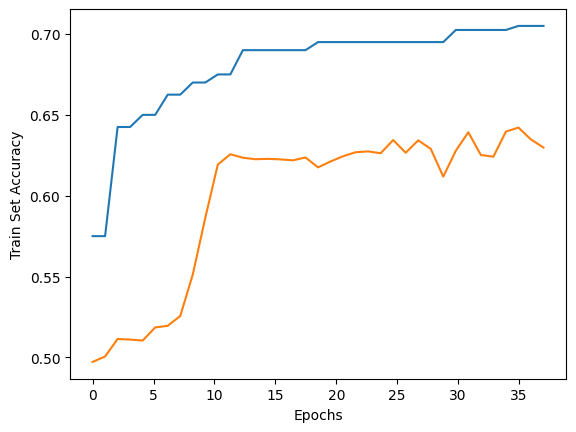

In [50]:
plt.ylabel('Train Set Accuracy')
plt.xlabel('Epochs')

plt.plot(np.linspace(0, len(best_fit_log), len(best_fit_log)), best_fit_log)
plt.plot(np.linspace(0, len(pop_fit_log), len(pop_fit_log)), pop_fit_log)